In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
print(torch.cuda.is_available())

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [2]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
N_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('N_FEATURES =', N_FEATURES)

N_STEPS = 1001
NUM_PARTICLES = 12
N_FEATURES = 24


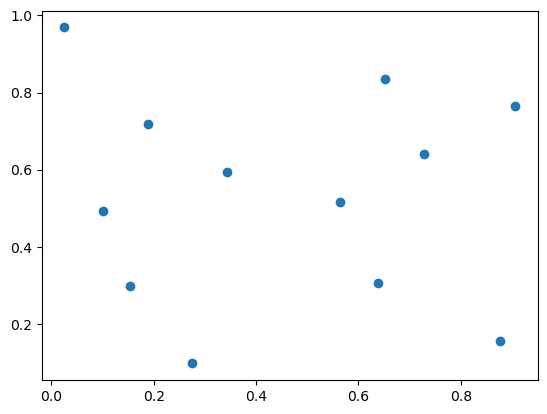

In [3]:
#trajectory[t,n,i]
#t-> time step
#n-> particle
#i-> x or y coordinate
t = -1 #last time step
plt.scatter(loaded_trajectory_pos[t,:,0]/LX, loaded_trajectory_pos[t,:,1]/LY, marker='o')

In [4]:
# Data preparation

#input X is the time step t; output Y the time step t+1
x = loaded_trajectory_pos[0:N_STEPS-1,:,:]/LX
y = loaded_trajectory_pos[1:N_STEPS,:,:]/LY
print(x.shape)
print(y.shape)
print(np.array_equal(x[1],y[0]))#just to check that the shifted time steps are correct

(1000, 12, 2)
(1000, 12, 2)
True


In [5]:
#Prepare the Dataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to torch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

n_total = x_tensor.size(0)
n_train = int(n_total * 0.8)
n_val = n_total - n_train

# Split the datasets into training and validation sets
x_train, x_val = torch.split(x_tensor, [n_train, n_val], dim=0)
y_train, y_val = torch.split(y_tensor, [n_train, n_val], dim=0)

x_train, y_train = x_train.to(device), y_train.to(device)
x_val, y_val = x_val.to(device), y_val.to(device)

In [6]:
class ODEfunc(nn.Module):
    def __init__(self, n_particles, degrees_of_freedom, n_layers=3):
        super().__init__()
        n_features = n_particles * degrees_of_freedom
        # Define the layers in a ModuleList
        self.flatten = nn.Flatten()
        # Define unflatten with a fixed size assuming the flattened size is n_particles * degrees_of_freedom
        self.unflatten = nn.Unflatten(1, (n_particles, degrees_of_freedom))
        layers = [nn.Linear(in_features=n_features, out_features=n_features) for _ in range(n_layers)]
        self.layers = nn.ModuleList(layers)
        # Define the activation function
        self.relu = nn.ReLU()
        
    def forward(self, t, x):
        # Note: Even if 't' is not used in the computation, it needs to be accepted as an argument
        x = self.flatten(x)
        # Iterate through all linear layers except the last to apply ReLU activation
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))
        x = self.layers[-1](x)  # Apply the last linear layer without activation
        x = self.unflatten(x)  # Unflatten to the original shape
        return x

In [7]:
ode_f = ODEfunc(n_particles=NUM_PARTICLES, degrees_of_freedom=DEG_FREED, n_layers=5).to(device)

In [8]:
from torchdiffeq import odeint_adjoint as odeint  # Use odeint_adjoint for the adjoint method

# Example of a single ODENet iteration to check that everything works
#input
x_tensor = x_tensor.to(device)
x_tensor.requires_grad=True
print('x_tensor ',x_tensor.shape)
# target
y_tensor = y_tensor.to(device)
print('y_tensor ',y_tensor.shape)

T_max = 1 #kind of arbitrary
t = torch.linspace(0, T_max, steps=10).to(device)  # Time points
print('t ',t.shape)
output = ode_f(t,x_tensor)
print('output', output.shape)

# Integrate the ODE
solution = odeint(ode_f, x_tensor, t, method='dopri5')
print('solution', solution.shape)

x_tensor  torch.Size([1000, 12, 2])
y_tensor  torch.Size([1000, 12, 2])
t  torch.Size([10])
output torch.Size([1000, 12, 2])
solution torch.Size([10, 1000, 12, 2])


In [9]:
optimizer = optim.Adam(ode_f.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

T_max = 1
t = torch.linspace(0, T_max, steps=10).to(device)  # Time points

losses = []
val_losses = []

num_epochs = 201

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear gradients
    
    # Training
    ode_f.train() 
    predicted_y_train = odeint(ode_f, x_train, t, method='dopri5')[-1]  
    loss = loss_fn(predicted_y_train, y_train)
    loss.backward()  
    optimizer.step() 
    losses.append(loss.item()) 
    
    # Validation
    ode_f.eval()
    with torch.no_grad():  
        predicted_y_val = odeint(ode_f, x_val, t, method='dopri5')[-1] 
        val_loss = loss_fn(predicted_y_val, y_val)
    val_losses.append(val_loss.item())  # Store validation loss
    
    if epoch % 50 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

Epoch 0, Training Loss: 0.0129, Validation Loss: 0.0127
Epoch 50, Training Loss: 0.0022, Validation Loss: 0.0023
Epoch 100, Training Loss: 0.0008, Validation Loss: 0.0011
Epoch 150, Training Loss: 0.0008, Validation Loss: 0.0010
Epoch 200, Training Loss: 0.0008, Validation Loss: 0.0010


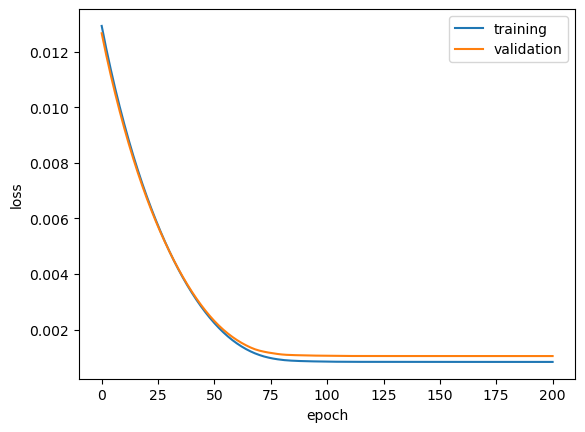

In [10]:
plt.plot(losses, label = 'training')
plt.plot(val_losses, label = 'validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare for prediction
real_xy = np.zeros_like(y_tensor.detach().cpu())  
predicted_xy = np.zeros_like(y_tensor.detach().cpu())

ode_f.eval()  # Set the model to evaluation mode

T_max = 1  # Define the time span for ODE integration
t = torch.linspace(0, T_max, steps=10).to(device)  # Time points for ODE solver

for i in range(len(real_xy)):
    pos_t_1 = x_tensor[i].unsqueeze(0)  # Initial condition for the ODE solver
    
    with torch.no_grad():  # No need to track gradients during inference
        # Solve the ODE starting from pos_t_1
        predicted_trajectory = odeint(ode_f, pos_t_1, t, method='dopri5')
        # Extract the predicted position at the last time step
        predicted_t = predicted_trajectory[-1]
    
    real_xy[i] = y_tensor[i].cpu().detach().numpy()  
    predicted_xy[i] = predicted_t.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and move to CPU

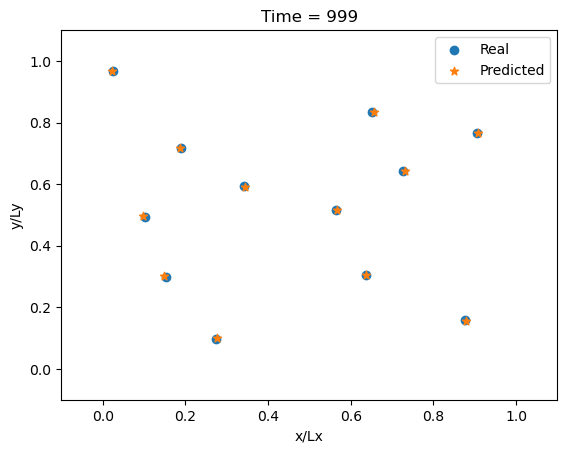

In [12]:
# Visualization for a specific time point
time = 999  # Index for the time step you want to visualize
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o', label='Real')
plt.scatter(predicted_xy[time,:,0], predicted_xy[time,:,1], marker='*', label='Predicted')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title(f'Time = {time}')
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.legend()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, pred_y, file_name):
    # Update function for the animation
    def update(frame_number, real_y, pred_y, scatter_real, scatter_pred, time_text):
        # Update the data of both scatter plots for the new frame
        scatter_real.set_offsets(real_y[frame_number])
        scatter_pred.set_offsets(pred_y[frame_number])
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('x/Lx')
    ax.set_ylabel('y/Ly')    
    # Create initial scatter plots and a text annotation
    scatter_real = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='blue', marker='o')
    scatter_pred = ax.scatter(pred_y[0, :, 0], pred_y[0, :, 1], color='orange', marker='*')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')
    
    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, pred_y, scatter_real, scatter_pred, time_text), interval=100)
    
    # Save the animation
    ani.save(file_name, writer='ffmpeg')
    
    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())
    
    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)
    
    # Return the HTML object to display the animation in the notebook
    return html

In [14]:
#make_video(real_xy, predicted_xy, file_name = 'predicted.mp4')

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare for prediction
fully_predicted_xy = np.zeros_like(y_tensor.detach().cpu())

ode_f.eval()  # Set the model to evaluation mode

T_max = 1  # Define the time span for ODE integration
t = torch.linspace(0, T_max, steps=10).to(device)  # Time points for ODE solver

fully_predicted_xy[0] = real_xy[0]

for i in range(1, len(real_xy)):
    pos_t_1 = torch.tensor(fully_predicted_xy[i-1], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():  # No need to track gradients during inference
        # Solve the ODE starting from pos_t_1
        fully_predicted_trajectory = odeint(ode_f, pos_t_1, t, method='dopri5')
        # Extract the predicted position at the last time step
        fully_predicted_t = fully_predicted_trajectory[-1]
    fully_predicted_xy[i] = fully_predicted_t.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and move to CPU

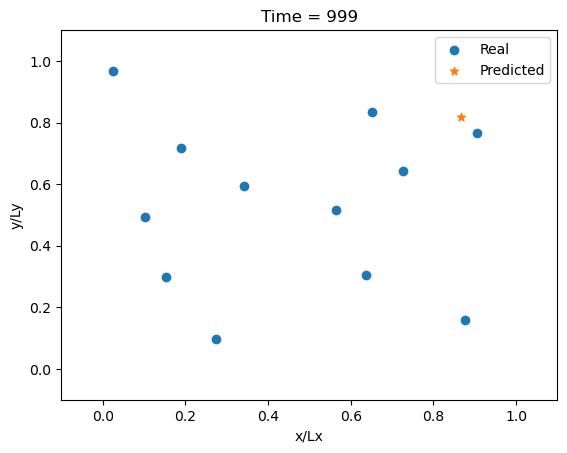

In [16]:
# Visualization for a specific time point
time = 999  # Index for the time step you want to visualize
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o', label='Real')
plt.scatter(fully_predicted_xy[time,:,0], fully_predicted_xy[time,:,1], marker='*', label='Predicted')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title(f'Time = {time}')
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.legend()
plt.show()

In [23]:
# Calculate squared differences for x and y coordinates
d1 = ((real_xy[:, :, 0] - predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
d2 = ((real_xy[:, :, 0] - fully_predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
# Sum the errors for all particles at each time step
overall_error_1 = np.sum(d1, axis=1)
overall_error_2 = np.sum(d2, axis=1)

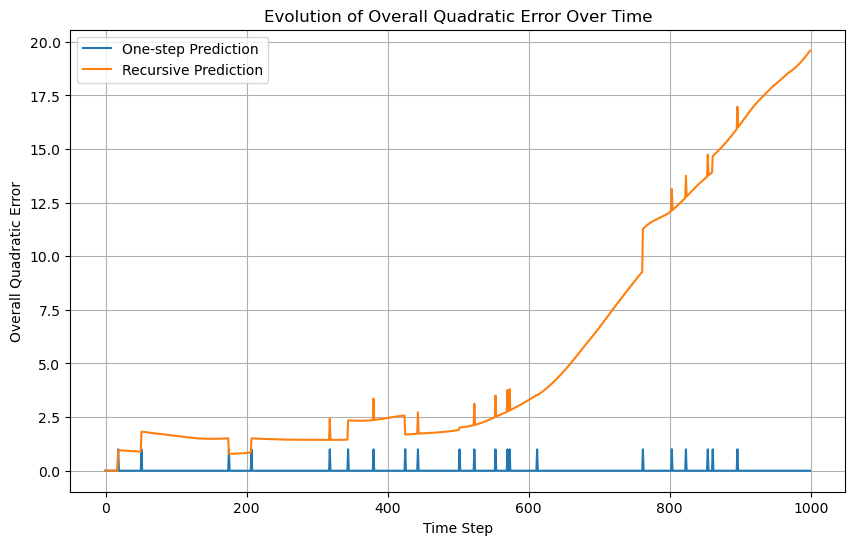

In [24]:
time_steps = np.arange(len(overall_error_per_timestep1))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, overall_error_1, label='One-step Prediction')
plt.plot(time_steps, overall_error_2, label='Recursive Prediction')
plt.xlabel('Time Step')
plt.ylabel('Overall Quadratic Error')
plt.title('Evolution of Overall Quadratic Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
import numpy as np
import torch
from torchdiffeq import odeint_adjoint as odeint

# predicting from i to i+2

# Prepare for prediction
predicted_xy_bis = np.full_like(y_tensor.detach().cpu().numpy(), fill_value=-99)

ode_f.eval()  # Set the model to evaluation mode

# Define the time span for ODE integration to cover i to i+2
T_max_bis = 2  # 2 * T_max for predicting two steps ahead
t_bis = torch.linspace(0, T_max_bis, steps=20).to(device)  # Adjust the number of steps as needed

# Use only half of the real_xy for initial conditions
for i in range(0, len(real_xy), 2):  # Skip every other entry
    if i + 2 < len(real_xy):  # Ensure we don't go out of bounds
        pos_t_1 = x_tensor[i].unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_trajectory_bis = odeint(ode_f, pos_t_1, t_bis, method='dopri5')
            predicted_t_bis = predicted_trajectory_bis[-1]
        predicted_xy_bis[i + 2] = predicted_t_bis.squeeze(0).cpu().detach().numpy()

# This checks if either coordinate in each particle's position is not -99
modified_mask = np.any(predicted_xy_bis != -99, axis=(1, 2))

# Apply the mask to filter out unmodified elements
predicted_xy_bis_filtered = predicted_xy_bis[modified_mask]
print(predicted_xy_bis.shape)
print(predicted_xy_bis_filtered.shape)
real_xy_filtered_bis = real_xy[modified_mask]
print(real_xy.shape)
print(real_xy_filtered_bis.shape)
time_steps = np.arange(len(real_xy))
time_steps_bis = time_steps[modified_mask]
mask_bis = modified_mask


(1000, 12, 2)
(499, 12, 2)
(1000, 12, 2)
(499, 12, 2)


In [60]:
# prediction from i tpo i+3
predicted_xy_ter = np.full_like(y_tensor.detach().cpu().numpy(), fill_value=-99)

# Define the time span for ODE integration to cover i to i+3
T_max_ter = 3  # 3 * T_max for predicting three steps ahead
t_ter = torch.linspace(0, T_max_ter, steps=30).to(device)  # Adjust the number of steps as needed

# Use only one third of the real_xy for initial conditions
for i in range(0, len(real_xy), 3):  # Skip every two entries
    if i + 3 < len(real_xy):  # Ensure we don't go out of bounds
        pos_t_1 = x_tensor[i].unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_trajectory_ter = odeint(ode_f, pos_t_1, t_ter, method='dopri5')
            predicted_t_ter = predicted_trajectory_ter[-1]
        predicted_xy_ter[i + 3] = predicted_t_ter.squeeze(0).cpu().detach().numpy()

# This checks if either coordinate in each particle's position is not -99
modified_mask = np.any(predicted_xy_ter != -99, axis=(1, 2))

# Apply the mask to filter out unmodified elements
predicted_xy_ter_filtered = predicted_xy_ter[modified_mask]
print(predicted_xy_ter.shape)
print(predicted_xy_ter_filtered.shape)
real_xy_filtered_ter = real_xy[modified_mask]
print(real_xy.shape)
print(real_xy_filtered_ter.shape)

time_steps = np.arange(len(real_xy))
time_steps_ter = time_steps[modified_mask]
predicted_xy_ter_filtered = predicted_xy_ter[modified_mask]
mask_ter = modified_mask

(1000, 12, 2)
(333, 12, 2)
(1000, 12, 2)
(333, 12, 2)


In [61]:
# prediction from i tpo i+5
predicted_xy_quintus = np.full_like(y_tensor.detach().cpu().numpy(), fill_value=-99)

# Define the time span for ODE integration to cover i to i+5
T_max_quintus = 5  # 5 * T_max for predicting three steps ahead
t_quintus = torch.linspace(0, T_max_quintus, steps=50).to(device)  

# Use only 1/5 of the real_xy for initial conditions
for i in range(0, len(real_xy), 5):  # Skip every 5 entries
    if i + 5 < len(real_xy):  # Ensure we don't go out of bounds
        pos_t_1 = x_tensor[i].unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_trajectory_quintus = odeint(ode_f, pos_t_1, t_quintus, method='dopri5')
            predicted_t_quintus = predicted_trajectory_quintus[-1]
        predicted_xy_quintus[i + 5] = predicted_t_quintus.squeeze(0).cpu().detach().numpy()

# This checks if either coordinate in each particle's position is not -99
modified_mask = np.any(predicted_xy_quintus != -99, axis=(1, 2))

# Apply the mask to filter out unmodified elements
predicted_xy_quintus_filtered = predicted_xy_quintus[modified_mask]
print(predicted_xy_quintus.shape)
print(predicted_xy_quintus_filtered.shape)
real_xy_filtered_quintus = real_xy[modified_mask]
print(real_xy.shape)
print(real_xy_filtered_quintus.shape)

time_steps = np.arange(len(real_xy))
time_steps_quintus = time_steps[modified_mask]
mask_quintus = modified_mask

(1000, 12, 2)
(199, 12, 2)
(1000, 12, 2)
(199, 12, 2)


In [62]:
# Prepare for prediction
predicted_xy_deciens = np.full_like(y_tensor.detach().cpu().numpy(), fill_value=-99)

# Define the time span for ODE integration to cover i to i+10
T_max_deciens = 10  # 10 * T_max for predicting ten steps ahead
t_deciens = torch.linspace(0, T_max_deciens, steps=100).to(device)  # Adjust the number of steps as needed

# Use only one-tenth of the real_xy for initial conditions
for i in range(0, len(real_xy), 10):  # Skip every nine entries (for a total skip of 10)
    if i + 10 < len(real_xy):  # Ensure we don't go out of bounds
        pos_t_1 = x_tensor[i].unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_trajectory_deciens = odeint(ode_f, pos_t_1, t_deciens, method='dopri5')
            predicted_t_deciens = predicted_trajectory_deciens[-1]
        predicted_xy_deciens[i + 10] = predicted_t_deciens.squeeze(0).cpu().detach().numpy()

# This checks if either coordinate in each particle's position is not -99
modified_mask_deciens = np.any(predicted_xy_deciens != -99, axis=(1, 2))

# Apply the mask to filter out unmodified elements
predicted_xy_deciens_filtered = predicted_xy_deciens[modified_mask_deciens]
print(predicted_xy_deciens.shape)
print(predicted_xy_deciens_filtered.shape)

real_xy_filtered_deciens = real_xy[modified_mask_deciens]
print(real_xy.shape)
print(real_xy_filtered_deciens.shape)

# To align the time steps with the filtered predictions
time_steps_deciens = np.arange(len(real_xy))[modified_mask_deciens]
mask_deciens = modified_mask_deciens

(1000, 12, 2)
(99, 12, 2)
(1000, 12, 2)
(99, 12, 2)


In [69]:
# Corrected error calculation for bis predictions
d_bis = ((real_xy_filtered_bis[:, :, 0] - predicted_xy_bis_filtered[:, :, 0])**2) + \
        ((real_xy_filtered_bis[:, :, 1] - predicted_xy_bis_filtered[:, :, 1])**2)

# Corrected error calculation for ter predictions
# Ensure you've similarly filtered predicted_xy_ter and real_xy for ter predictions
d_ter = ((real_xy_filtered_ter[:, :, 0] - predicted_xy_ter_filtered[:, :, 0])**2) + \
        ((real_xy_filtered_ter[:, :, 1] - predicted_xy_ter_filtered[:, :, 1])**2)

# Corrected error calculation for quintus predictions
d_quintus = ((real_xy_filtered_quintus[:, :, 0] - predicted_xy_quintus_filtered[:, :, 0])**2) + \
        ((real_xy_filtered_quintus[:, :, 1] - predicted_xy_quintus_filtered[:, :, 1])**2)

# Corrected error calculation for deciens predictions
d_deciens = ((real_xy_filtered_deciens[:, :, 0] - predicted_xy_deciens_filtered[:, :, 0])**2) + \
        ((real_xy_filtered_deciens[:, :, 1] - predicted_xy_deciens_filtered[:, :, 1])**2)

# Sum the errors for all particles at each time step
overall_error = 100*np.sum(d1)/np.sum(real_xy)
overall_error_bis = 100*np.sum(d_bis)/np.sum(real_xy_filtered_bis)
overall_error_ter = 100*np.sum(d_ter)/np.sum(real_xy_filtered_ter)
overall_error_quintus = 100*np.sum(d_quintus)/np.sum(real_xy_filtered_quintus)
overall_error_deciens = 100*np.sum(d_deciens)/np.sum(real_xy_filtered_deciens)
print(overall_error)
print(overall_error_bis)
print(overall_error_ter)
print(overall_error_quintus)
print(overall_error_deciens)

0.18779832043604375
0.5533523979279897
0.8011480200851046
1.116169500480297
2.0542558152326436


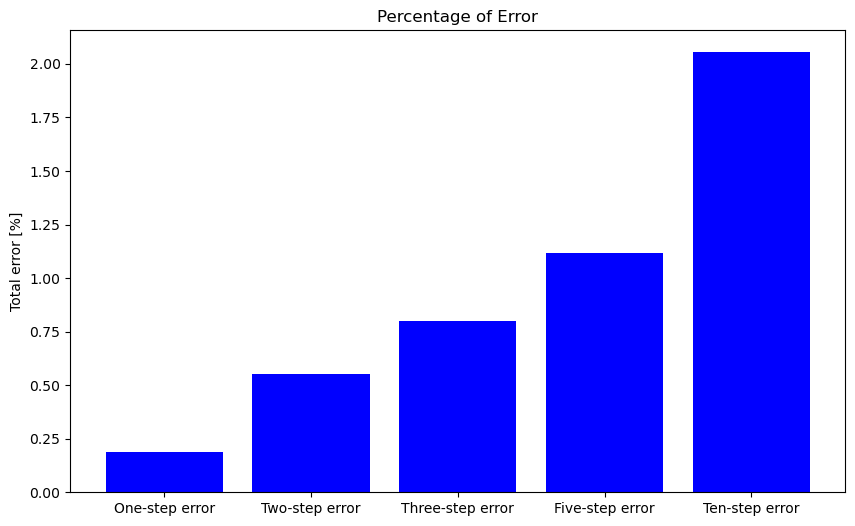

In [73]:
import matplotlib.pyplot as plt

# Labels for the x-axis
labels = ['One-step error', 'Two-step error', 'Three-step error', 'Five-step error', 'Ten-step error']

# Corresponding values
values = [overall_error, overall_error_bis, overall_error_ter, overall_error_quintus, overall_error_deciens]

# Creating the bar plot
plt.figure(figsize=(10, 6))  
plt.bar(labels, values, color='blue')

# Adding labels and title
plt.ylabel('Total error [%]')
plt.title('Percentage of Error')

# Show plot
plt.xticks(rotation=0)  
plt.show()
